# *Krankenkassenpraemien: explorative analysis*

In [2]:
import pandas as pd
import numpy as np

import csv

#!pip install plotly
import plotly as pl
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

import seaborn as sn

import matplotlib.pyplot as plt

### 1. Intro

In the visual part of the exploration we look at two things:
a) Distribution of values in a single variable, 
b) Relationship between two variables.

Question to answer: Which variables and what are their values that bring medical costs up(down?)

Goal: We wish to include more data from areas where health issues results from an individuals actions / life-style. Personal choice would thus directly adjust the medical cost.

1. We will visually examine which variable values are most closely correlated with high/low charges.
2. Of the variables which most affect medical costs we will consider only those which can be ethically utilized (acquired and not congenital) in building a model.

Hypothesis after visual analysis: smoking affects health most prominently. A smoker with BMI > ~25 or PBF > ~40 incurs higher medical costs.

### 2. Dataset inspection

In [6]:
# read the data, '';'-separated
df = pd.read_csv('data_insurance.csv', sep=';')
print()
print("Sample of entries") 
print()
print(df.head())
print()
print()
print("Data types of the columns in the dataframe") 
display(df.dtypes)


Sample of entries

   Alter Geschlecht     BMI  Kinder Raucher Kanton    PBF Zahlungen
0     19          w  24.720       0      ja     SO  35.94     4’253
1     18          m  29.416       1    nein     AG  26.86     2’494
2     28          m  28.800       3    nein     AG  26.92     3’138
3     33          m  20.564       0    nein     BS   7.98     1’553
4     32          m  25.504       0    nein     BS  21.84     2’768


Data types of the columns in the dataframe


Alter           int64
Geschlecht     object
BMI           float64
Kinder          int64
Raucher        object
Kanton         object
PBF           float64
Zahlungen      object
dtype: object

In [9]:
# Changing the variable type
df['Zahlungen'] = df['Zahlungen'].str.replace("’", "").apply(pd.to_numeric)

# Factorize variables with limited no. of values, if only 2 possible values: use Boolean.
# Factorized columns are to be used in the decison tree model
df['Geschlecht_f'] = df.apply(
    lambda x: True if x['Geschlecht'] == 'w' else False,
    axis=1)
df['Raucher_f'] = df.apply(
    lambda x: True if x['Raucher'] == 'ja' else False,
    axis=1)

In [10]:
df

,Alter,Geschlecht,BMI,Kinder,Raucher,Kanton,PBF,Zahlungen,Geschlecht_f,Raucher_f
0,19,w,24.720,0,ja,SO,35.94,4253,True,True
1,18,m,29.416,1,nein,AG,26.86,2494,False,False
2,28,m,28.800,3,nein,AG,26.92,3138,False,False
3,33,m,20.564,0,nein,BS,7.98,1553,False,False
4,32,m,25.504,0,nein,BS,21.84,2768,False,False
...,...,...,...,...,...,...,...,...,...,...
1333,50,m,27.176,3,nein,BS,23.02,5767,False,False
1334,18,w,27.936,0,nein,BL,42.18,2547,True,False
1335,18,w,31.880,0,nein,AG,49.59,3026,True,False
1336,21,w,23.040,0,nein,SO,31.18,2208,True,False


In [11]:
# Checking for missing values
print()
print("Completness of the dataset:")
print()
print("Missing values in Alter:", any(df.Alter.isna()))
print("Missing values in BMI:", any(df.BMI.isna()))
print("Missing values in Kinder:", any(df.Kinder.isna()))
print("Missing values in Kanton:", any(df.Kanton.isna()))
print("Missing values in PBF:", any(df.PBF.isna()))
print("Missing values in Zahlungen:", any(df.Zahlungen.isna()))
print()
# Checking for duplictated entries or discrepancies/inconsistencies
print("Unique values of the variables:")
print()
print("Geschlecht values:", df["Geschlecht"].unique())
print("Raucher values:", df["Raucher"].unique())
print("Kinder values:", df["Kinder"].unique())


Completness of the dataset:

Missing values in Alter: False
Missing values in BMI: False
Missing values in Kinder: False
Missing values in Kanton: False
Missing values in PBF: False
Missing values in Zahlungen: False

Unique values of the variables:

Geschlecht values: ['w' 'm']
Raucher values: ['ja' 'nein']
Kinder values: [0 1 3 2 5 4]


### 3. Variable distribution and outliers

In [12]:
print("Descriptive statistics")
df.describe()

Descriptive statistics


,Alter,BMI,Kinder,PBF,Zahlungen
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,26.930717,1.094918,31.676084,6692.947683
std,14.049960,4.878550,1.205493,12.017068,5971.521247
min,18.000000,15.168000,0.000000,-0.750000,1171.000000
25%,27.000000,23.437000,0.000000,22.905000,3292.250000
50%,39.000000,26.720000,1.000000,30.985000,4847.000000
75%,51.000000,30.155000,2.000000,40.000000,7862.250000
max,64.000000,44.904000,5.000000,66.270000,59703.000000


Here we hope to notice some outliers. They could negatively affect our models later and should be removed.

According to WHO is BMI of 40+ defined as Grade III obesity. Only about 25% of people have BMI over 30 (Wikipedia) - this checks out. But a BMI of almost 45 could be unusual - check the BMI distribution below.

Secondly, typical PBF/BFP (Wikipedia) until age 60 remains under 40%, and the majority of the population has a BFP under 40% - this also checks out. But we should examine the max. value of 66.27%. It signifies extreme obesity, yet the value is not completely impossible. What is impossible, is the value -0.75% body fat and the record should be removed or adjusted by the insurance company with correct data. #ASK

For athletic people, PBF is a better predictor of health and fitness. Thus, an important info would be, if the client is an active person or a couch potato. #ASK


Variable distribution

Alter


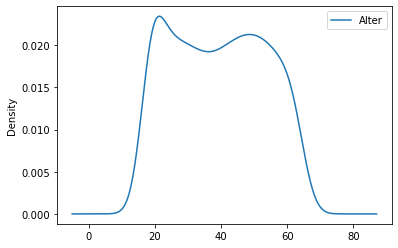

BMI


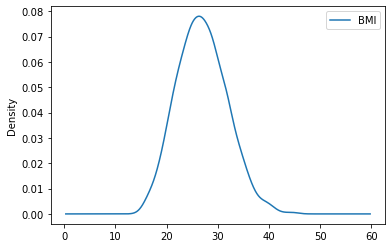

PBF


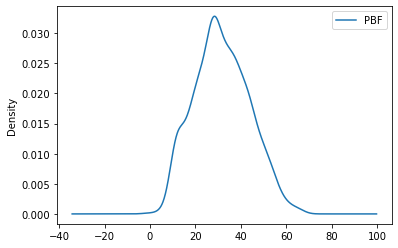

Zahlungen


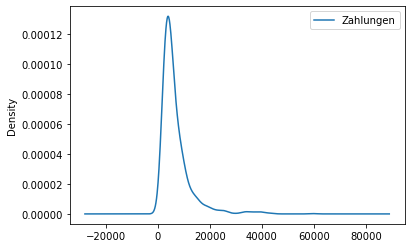

In [23]:
print()
print('Variable distribution')
def distribution(data, col_name):
    print(col_name)
    col_data = pd.DataFrame(data, columns = [col_name])
    col_data.plot(kind = 'density')
    plt.show()

print()
distribution(df, 'Alter') #bimodal?
distribution(df, 'BMI') # normal distribution
distribution(df, 'PBF') # normal distribution
distribution(df, 'Zahlungen') # rechtsschief Verteilung

1. Age (Alter):
Bimodal distribution. The mean may be a more robust sample estimator than the median - true sometimes for bimodal distribution. (As a mixture of two or more different unimodal distributions, like height for females and males? Which different groups are these? People with and without children? Smokers vs non-smokers? Does it even matter? NO.)

2. BMI:
Normal distribution.

3. PBF:
Normal distribution.

4. Charges (Zahlungen): 
Right-skewed distribution (Mode < Median < Mean).
There are a few clients with very high charges and a lot of clients with rather low charges.

We'll look for the outliers with a scatterplot matrix.

In [39]:
fig = px.scatter_matrix(df, dimensions=
['Alter', 'BMI', 'PBF', 'Zahlungen'],
                        labels={col:col.replace('_', ' ') for col in df.columns},
                        width=1000,
                        height=1000)
fig.show()

**Alter**  
Look at the comments under BMI and Zahlungen.

**BMI**  
For 3 clients aged around 20 a BMI of 40+ is unusual. In a real situation this should be double-checked with the insurance comany, since such cominations of data could really ruin our models.
3 clients with BMI around 44 could be considered outliers or not? #ASK

**PBF**  
The negative value -0.75 was mentioned above. Another strange thing is unusually many people with PBF around and over 60%. - more than one would expect statistically. Is this deviation due to a too small sample?

**Zahlungen**  
All bivariate relationships suggest that the charge of CHF 59,703 is an outlier. The record should be removed.

In [29]:
# Behaviour of "Zahlungen" with a histogram, represent the percentage or fraction of samples in each bin
fig = px.histogram(df, 
                   x = "Zahlungen",
                   histnorm='percent',
                   title = "Charges")
fig.show()

### Bivariate relationships
##### 1. Age +  children / sex / smoking vs. charges

In [36]:
# 1. Age-children-charges relationship
fig = px.histogram(df, 
                   x = 'Alter', 
                   y = 'Zahlungen',
                   color = 'Kinder',
                   title = '1. Age + children')
fig.show()

# 2. Age-gender-charges relationship
# Separate histograms for both sexes, preparing dfs
df_w = df[(df['Geschlecht']=='w')][['Alter', 'Geschlecht', 'Zahlungen']]
df_m = df[(df['Geschlecht']=='m')][['Alter', 'Geschlecht', 'Zahlungen']]
# Female/male population of clients    
x0 = df_w['Zahlungen']
x1 = df_m['Zahlungen']

fig = go.Figure()
fig.add_trace(go.Histogram(x=x0,
                           histnorm='percent',
                           name='female clients'))
fig.add_trace(go.Histogram(x=x1,
                           histnorm='percent',
                           name='male clients'))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.55)

# Add suitable titles/labels
fig.update_layout(
    title_text='2. Age + gender', # title of plot
    xaxis_title_text='Charges', # xaxis label
    yaxis_title_text='Age') # yaxis label
fig.show()

# 3. Age-smoking charges connections, averge per patient
fig = px.bar(df.groupby('Alter').mean().reset_index(), # reset index since new values are added - the means of age groups 
             x = 'Alter',
             y = 'Zahlungen',
             color = 'Raucher_f',
             labels={"Raucher_f": "Ratio of smokers"}) # change the name of the legend

fig.update_layout(
    title_text='3. Age + smoking', # title of plot
    xaxis_title_text='Age group with the % of smokers', # xaxis label
    yaxis_title_text='Charges, mean per client') # yaxis label
fig.show()



**Children**: there seems to be no connection between the no. of children and related medical costs per client.  
**Sex**: Female clients incur higher charges sooner (child-bearing years?).  
**Smoking**: Age groups that have higher ratio of smokers experience in comparison to neighbouring age groups unexpectedly higher medical costs. A strange deviation: in age group 43, there are 44% of smokers. This could be unusual, because the smoking prevalence in Switzerland is supposed to be around 25%.

Example of a pattern:  

- age = 26 and 28  
- ratio of smokers ~ 0.1  
- charges ~ 3956, 4187  

  
- age = 27  
- smokers ~ 0.30  
- charges ~ 5095

In [38]:
# Unusual no. of children for this age ... bad data? #ASK
df[(df['Alter']<=21) & (df['Kinder'] == 5)]

,Alter,Geschlecht,BMI,Kinder,Raucher,Kanton,PBF,Zahlungen,Geschlecht_f,Raucher_f
32,19,w,25.280,5,nein,SO,37.84,2661,True,False
166,20,w,32.000,5,nein,SO,49.58,4344,True,False
984,20,m,26.492,5,nein,BL,24.02,3194,False,False


In [9]:
# Does BMI always have the same effect? (independent from age, smoking?)

fig = px.scatter(df, x = 'BMI',
               y = 'Zahlungen',
               color = 'Raucher',
               trendline = 'ols',
               title = 'BMI vs. costs + linear')
fig.data[1].line.color = 'green'
fig.data[3].line.color = 'black'
fig.show()

fig = px.scatter(df, x = 'BMI',
               y = 'Zahlungen',
               color = 'Raucher',
               trendline = "lowess",
               title = 'BMI vs. costs + non-linear fit')
fig.data[1].line.color = 'green'
fig.data[3].line.color = 'black'
fig.show()

Non-linear fit shows that a BMI of 25 or more (a break in trend happens at approx. BMI = 25) affects medical costs even more strongly. 

Suggestion: Instead of trying to manually find turn points where insurance charges become steeper (the semi-failed commented attempt below), the "groups" of charges could be found using the k-clustering method.

In [63]:
# linear regression line
fig = px.scatter(df, x = 'PBF', 
                 y = 'Zahlungen',
                 trendline='ols',
                 title = 'Costs and PBF')
fig.data[1].line.color = 'red'
fig.show()

# non-linear regression
fig = px.scatter(df, x = 'PBF', y = 'Zahlungen', trendline="lowess")
fig.data[1].line.color = 'red'
fig.show()

print()
print('PBF Stats')
df['PBF'].describe()


PBF Stats


count    1338.000000
mean       31.676084
std        12.017068
min        -0.750000
25%        22.905000
50%        30.985000
75%        40.000000
max        66.270000
Name: PBF, dtype: float64

Up to PBF = 40 the charges increase more slowly than for PBF = 40+.

What is with the PBF = -0.75 value? Remove observation?

In [12]:
fig = px.bar(df.groupby('Kinder').mean().reset_index(),
             x = 'Kinder', 
             y = 'Zahlungen',
             color = 'Kinder',
             title = 'No. of children vs. average charges')
fig.show()

Is mean charge affected by the number of children?
How to make the legend more categoric-value-appropriate?

### Smokers vs non-smokers

In [13]:
# relationship "Smoking and charges"
fig = px.scatter(df, x = 'Alter',
                 y = 'Zahlungen',
                 color = 'Raucher',
                 trendline = 'lowess',
                 title = 'At what age smokers start to incur even more expenses?')
fig.show()

In [14]:
fig = px.box(df, x = 'Raucher', y = 'Zahlungen')
fig.show()

In [15]:
df_smokers = df[df['Raucher_f'] == True] [['Alter', 'Zahlungen']]
df_smokers = df_smokers.sort_values(by = ['Alter'], ascending = True)
print(df_smokers.describe())
df_smokers.head()

            Alter     Zahlungen
count  274.000000    274.000000
mean    38.514599  12757.062044
std     13.923186   9470.759076
min     18.000000   3598.000000
25%     27.000000   6371.000000
50%     38.000000   9279.000000
75%     49.000000  15559.750000
max     64.000000  59703.000000


,Alter,Zahlungen
759,18,7413
161,18,6254
623,18,6049
1282,18,4088
803,18,9949


In [16]:
fig = px.scatter(df_smokers, x = 'Alter', y = 'Zahlungen', trendline="lowess")
fig.data[1].line.color = 'green'
fig.show()

Smokers have consistently higher charges over the entire life-span, the discrepancy between smokers and non-smokers becoming even greater at age 45.
Smokers' medical costs: 3598 - 43,749, with med = 9279.

Non-smokers med. cost: 1171 - 22,180, with med = 4303.5

It is not a congenital condition, thus a surcharge is ethical. (Find articles/arguments regading ethics.)

Estimate charges - the ratio between smokers' median and the non-smokers' median could serve to estimate how much more the smokers should pay?

Model: find the most important factors (smoking, bmi, age); arrange them ordinally (to which extent the factor affects the result? Eigenvalues?)

What is the exact age when the slope of the charges function changes significantly (around 45, 46 years?)
Here k-clustering would be a better choice than to do it manually.

### Regional differences

In [18]:
# What regions do we have?
print(df.Kanton.unique())

# changing string region name to discrete values
# 2. renaming string values into numeric ids
df['kanton_id'] = df['Kanton'].map({'SO': 1,
                                    'AG': 2,
                                    'BS': 3,
                                    'BL': 4})


['SO' 'AG' 'BS' 'BL']


In [19]:
# Which regions have the highest costs, any correlations?
# Use slider to choose a segment of values for each variable.

fig = px.parallel_coordinates(df, color = 'kanton_id',
                              color_continuous_scale = px.colors.diverging.Tealrose,
                              color_continuous_midpoint = 2)
fig.show()

AG has patients with the highest PBF / BMI and also the highest costs. Do these correlate? Does smoking also correlate with high BMI and high costs? Age histogram of AG in comparison to others?

In [20]:
# Average costs by region
fig = px.box(
    df,
    x = 'Kanton',
    y = 'Zahlungen',
    color = 'Kanton',
    title = 'Charges per region')
fig.show()

In [21]:
# Costs by region
fig = px.bar(
    df,
    x = 'Kanton',
    y = 'Zahlungen',
    color = 'Kanton',
    orientation = 'v',
    title = 'Charges per region - sum')
fig.show()

fig = px.bar(
    df.groupby('Kanton').mean().reset_index(),
    x = 'Kanton',
    y = 'Zahlungen',
    color = 'Kanton',
    orientation = 'v',
    title = 'Charges per region - average per client')
fig.show()

Sum: - What is the reason for high expense in AG? Just more people, or do the patients spend more? Let's take a look at mean charges. AG > BS > BL > SO
Mean: - AG > BS > BL > SO

Possible options to check:
- distribution of patiens across age and kantons,
- more careful analysis of AG, if its population displays characteristis which predict high medical cost.

In [22]:
# Costs by region - what is the reason for the differences? Smoking, BMI, family, gender?
ds = df.groupby(['Kanton', 'Raucher'])['Zahlungen'].mean().reset_index()
ds.columns = ['Kanton', 'Raucher', 'Zahlungen']

fig = px.bar(
ds,
x = 'Kanton',
y = 'Zahlungen',
color = 'Raucher',
barmode = 'group',
orientation = 'v',
title = 'Charges per region - mean per person')
fig.show()

With the AG smokers the costs are the higest: high BMI + smoking -> high charges.
Charges per individual smoker are higher, because smokers in AG are also at the same time overweight?

In [23]:
ds = df.groupby(['Kanton', 'Zahlungen'])['BMI'].mean().reset_index()
ds['BMI'].round(decimals=2)

fig = px.bar(
    ds,
    x = 'Kanton',
    y = 'Zahlungen',
    color = 'BMI',
    barmode = 'group',
    orientation = 'v',
    title = 'Charges per region with relation to BMI')
fig.show()

Visual inspection shows that the largest costs are mostly paid by the clients with a high BMI (top of the bars is mostly yellow -> BMI approx. 40+, bottom of the bars is violet or bluish -> BMI approx. 20-25.)

##### Correlation matrix

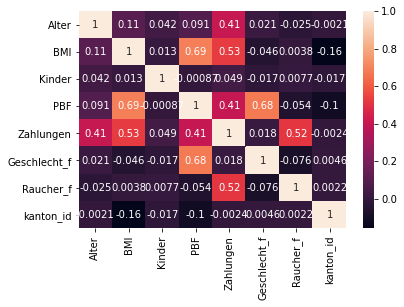

In [24]:
# correlation matrix - all variables vs. the charges
corrMatrix = df.corr()

# heatmap correlation matrix
sn.heatmap(corrMatrix, annot=True)
plt.show()


Correlation in fields:
- Zahlungen-Alter(0.41), 
- Zahlungen-BMI(0.53), 
- Zahlungen-PBF(0.41), 
- Zahlungen-Raucher (0.52)

are higher as expected with independent variables, which indicates that these variables are positively correlated with the charges.  

Correlation between BMI and PBF was a given. It can be maybe sorted our with orthonormalization?

Strongly related to higher medical costs:  
1) higher BMI/PBF (BMI correlates better),
2) smoking, 
3) advanced age,
4) PBF.

The Zahlungen-Geschlecht also correlate, but surcharge on the basis of gender ... is it ethical?
However, a surcharge could happen, if based on other features.

### Further questions & to-dos

Which libraries are allowed, are pandas and numpy allowed at all?
For model building, we can't use any libraries either?

Is matrix multiplication a possible tool that would advise clients how could their direct actions affect their premiums? E.g. their BMI, at what factor does a 5-point increase in BMI affect the premium?

#ASK Code source when following tutorials? Licenses? 

**TO-DO**  
Remove the outliers in Main.ipynb: 
- PBF -0.75 pbf 
- ZAHLUNG 59,703
- unusual data: 20-somethings with 5 kids, 20-somethings with BMI 40+ ...